## Inputs & Constants

In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm

In [0]:
IMG_SIZE = 320
IMPRESSIONIST_CLASSES = 10
IMPRESSIONIST_DIR = 'impressionist-classifier-data/'
IMPRESSIONIST_TRAIN = IMPRESSIONIST_DIR + 'training/training/'
IMPRESSIONIST_VALID = IMPRESSIONIST_DIR + 'validation/validation/'

In [0]:
from google.colab import drive
GOOGLE_DRIVE_MOUNT = "/content/gdrive"
drive.mount(GOOGLE_DRIVE_MOUNT)

## Loading paintings dataset

In [0]:
!kaggle datasets download -d delayedkarma/impressionist-classifier-data

100% 2.18G/2.19G [00:31<00:00, 65.1MB/s]
100% 2.19G/2.19G [00:31<00:00, 74.8MB/s]


In [0]:
with zipfile.ZipFile("impressionist-classifier-data.zip","r") as zip_ref:
    zip_ref.extractall(IMPRESSIONIST_DIR)

VanGogh (1024, 581, 3)


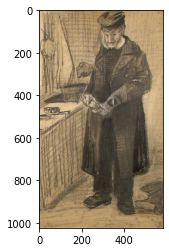

In [0]:
# show random picture from train
painter = random.choice(os.listdir(IMPRESSIONIST_TRAIN))
subdir = IMPRESSIONIST_TRAIN + painter + '/'
image_path = subdir + random.choice(os.listdir(subdir))

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(painter, image.shape)
plt.imshow(image)
plt.show()

## Convolutional encoder

### Train generator

In [0]:
impressionists_to_labels, labels_to_impressionists = {}, {}
for i, painter in enumerate(sorted(os.listdir(IMPRESSIONIST_TRAIN))):
    impressionists_to_labels[painter] = i
    labels_to_impressionists[i] = painter

In [0]:
def crop_picture(image, center):
    if image.shape[0] <= IMG_SIZE:
        left, right = 0, image.shape[0]
    elif center:
        left = (image.shape[0] - IMG_SIZE) // 2
        right = left + IMG_SIZE
    else:
        left = np.random.randint(image.shape[0] - IMG_SIZE)
        right = left + IMG_SIZE
    
    if image.shape[1] <= IMG_SIZE:
        top, bottom = 0, image.shape[1]
    elif center:
        top = (image.shape[1] - IMG_SIZE) // 2
        bottom = top + IMG_SIZE
    else:
        top = np.random.randint(image.shape[1] - IMG_SIZE)
        bottom = top + IMG_SIZE

    cropped_image = image[left: right, top: bottom]
    cropped_image = cv2.flip(cropped_image, 1)

    if cropped_image.shape[0] != IMG_SIZE or cropped_image.shape[1] != IMG_SIZE:
        cropped_image = cv2.resize(cropped_image, (IMG_SIZE, IMG_SIZE))
    
    return cropped_image

In [0]:
def load_random_picture(directory, painters_to_labels):
    painter = random.choice(os.listdir(directory))
    subdir = directory + painter + '/'
    image_path = subdir + random.choice(os.listdir(subdir))
    label = painters_to_labels[painter]

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.flip(image, 1)

    return image, label

In [0]:
def generator(directory, painters_to_labels, batch_size, num_classes, noise=None):
    while True:
        images, labels = [], []
        for _ in range(batch_size):
            image, label = load_random_picture(directory, painters_to_labels)
            image = image / 255 - 0.5
            if noise is not None:
                image += noise * np.random.normal(0, noise, image.shape)
            images.append(image)
            labels.append(label)
        images = np.stack(images)
        labels = keras.utils.to_categorical(labels, num_classes)
        yield images, labels

Degas


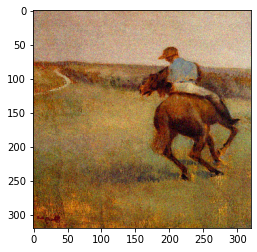

In [0]:
for images, labels in generator(IMPRESSIONIST_TRAIN, impressionists_to_labels, 
                                1, IMPRESSIONIST_CLASSES, noise=0.25):
    print(labels_to_impressionists[np.argmax(labels[0])])
    plt.imshow(np.clip(images[0] + 0.5, 0, 1))
    break

### Architecture

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, \
                         Dropout, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU

In [0]:
def conv_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(128))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))

    model.add(Dense(IMPRESSIONIST_CLASSES))
    model.add(Activation('softmax'))

    return model

In [0]:
K.clear_session()
model = conv_model()

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 320, 320, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 320, 320, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 160, 160, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 160, 160, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 160, 160, 64)      18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 160, 160, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 80, 80, 64)       

### Training

In [0]:
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras.models import save_model

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
BATCH_SIZE = 64
STEPS_PER_EPOCH = 100
EPOCHS = 20
VALIDATION_STEPS = 10
CHECKPOINT_TEMPLATE = GOOGLE_DRIVE_MOUNT + '/My Drive/impressionists_classification_{}'

In [0]:
model.compile(
    loss='categorical_crossentropy',
    metrics=[categorical_accuracy, top_3_accuracy],
    optimizer='adam'
)

In [0]:
model.fit(
    generator(IMPRESSIONIST_TRAIN, impressionists_to_labels, BATCH_SIZE,
              IMPRESSIONIST_CLASSES, noise=0.2),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    initial_epoch=10,
    validation_data=generator(IMPRESSIONIST_VALID, impressionists_to_labels,
                              BATCH_SIZE, IMPRESSIONIST_CLASSES),
    validation_steps=VALIDATION_STEPS,
    callbacks=[ModelSaveCallback(CHECKPOINT_TEMPLATE)],
    verbose=1
)

Epoch 11/20
100/100 [==============================] - 277s 3s/step - loss: 1.1032 - categorical_accuracy: 0.6239 - top_3_accuracy: 0.8763 - val_loss: 2.1101 - val_categorical_accuracy: 0.4578 - val_top_3_accuracy: 0.7937
Model saved in /content/gdrive/My Drive/impressionists_classification_10
Epoch 12/20
100/100 [==============================] - 274s 3s/step - loss: 1.1210 - categorical_accuracy: 0.6181 - top_3_accuracy: 0.8766 - val_loss: 1.7952 - val_categorical_accuracy: 0.4531 - val_top_3_accuracy: 0.7953
Model saved in /content/gdrive/My Drive/impressionists_classification_11
Epoch 13/20
100/100 [==============================] - 273s 3s/step - loss: 1.0741 - categorical_accuracy: 0.6370 - top_3_accuracy: 0.8808 - val_loss: 2.4373 - val_categorical_accuracy: 0.4203 - val_top_3_accuracy: 0.7422
Model saved in /content/gdrive/My Drive/impressionists_classification_12
Epoch 14/20
100/100 [==============================] - 272s 3s/step - loss: 1.0813 - categorical_accuracy: 0.6317 -

### Evaluation

In [0]:
from keras.models import load_model
K.clear_session()
model = load_model(
    CHECKPOINT_TEMPLATE.format(7),
    custom_objects={"top_3_accuracy": top_3_accuracy}
)

In [0]:
model.evaluate(
    generator(IMPRESSIONIST_TRAIN, impressionists_to_labels, BATCH_SIZE,
              IMPRESSIONIST_CLASSES),
    steps=30,
    verbose=1,
)

30/30 [==============================] - 51s 2s/step


[0.9023784399032593, 0.6640625, 0.890625]

In [0]:
model.evaluate(
    generator(IMPRESSIONIST_VALID, impressionists_to_labels, BATCH_SIZE,
              IMPRESSIONIST_CLASSES),
    steps=30,
    verbose=1,
)

30/30 [==============================] - 50s 2s/step


[1.4494136571884155, 0.5916666388511658, 0.8479166626930237]

Preds: ['Sargent', 'Matisse', 'Degas']
Truth: Sargent


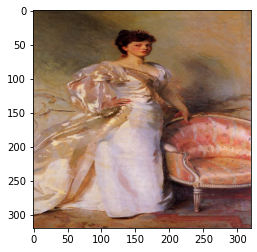

In [0]:
image, label = load_random_picture(IMPRESSIONIST_VALID, impressionists_to_labels)
proba = model.predict_proba(image[np.newaxis, :] / 255 - 0.5)[0]
preds = np.flip(np.argsort(proba)[-3:])
print('Preds:', [labels_to_impressionists[pred] for pred in preds])
print('Truth:', labels_to_impressionists[label])
plt.imshow(image)
plt.show()

## Embeddings generation

In [0]:
def iterate_directory(directory, painters_to_labels, batch_size):
    images, labels = [], []
    for painter in tqdm(sorted(os.listdir(directory))):
        subdir = directory + painter + '/'
        for filename in sorted(os.listdir(subdir)):
            image = cv2.imread(subdir + filename)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            image = image / 255 - 0.5

            images.append(image)
            labels.append(painters_to_labels[painter])
            if len(images) == batch_size:
                yield np.stack(images), np.array(labels)
                images, labels = [], []

    if len(images) > 0:
        yield np.stack(images), np.array(labels)

In [0]:
def generate_embeddings(directory, painters_to_labels, batch_size, functor):
    X, y = None, None
    for images, labels in iterate_directory(directory, painters_to_labels, batch_size):
        embeds = functor([images])[0]
        if y is None:
            X, y = embeds, labels
        else:
            X = np.concatenate((X, embeds))
            y = np.concatenate((y, labels))
    
    return X, y

In [0]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [0]:
outputs = [layer.output for layer in model.layers]
get_embeddings_avpool = K.function([model.input, K.learning_phase()], [model.layers[-9].output])

In [0]:
X, y = generate_embeddings(IMPRESSIONIST_TRAIN, impressionists_to_labels, 64, get_embeddings_avpool)

In [0]:
np.save(GOOGLE_DRIVE_MOUNT + '/My Drive/embeds_avpool_train.npy', X)
np.save(GOOGLE_DRIVE_MOUNT + '/My Drive/labels_avpool_train.npy', y)

In [0]:
X, y = generate_embeddings(IMPRESSIONIST_VALID, impressionists_to_labels, 64, get_embeddings_avpool)

In [0]:
np.save(GOOGLE_DRIVE_MOUNT + '/My Drive/embeds_avpool_test.npy', X)
np.save(GOOGLE_DRIVE_MOUNT + '/My Drive/labels_avpool_test.npy', y)

## Baseline

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMClassifier

In [0]:
X_train = np.load(GOOGLE_DRIVE_MOUNT + '/My Drive/embeds_avpool_train.npy')
y_train = np.load(GOOGLE_DRIVE_MOUNT + '/My Drive/labels_avpool_train.npy')
X_test = np.load(GOOGLE_DRIVE_MOUNT + '/My Drive/embeds_avpool_test.npy')
y_test = np.load(GOOGLE_DRIVE_MOUNT + '/My Drive/labels_avpool_test.npy')

In [0]:
def top_3_accuracy_score(y_true, probas):
    preds = np.argsort(probas, axis=1)[:, -3:]
    matches = np.zeros_like(y_true)
    for i in range(3):
        matches += (preds[:, i] == y_true)
    return matches.sum() / matches.size

def scorer(estimator, X, y):
    return accuracy_score(y, estimator.predict(X))

### Logistic Regression

In [0]:
param_grid = {'C': [1, 10, 100, 1000], 'max_iter': [10000]}
log_regr = GridSearchCV(LogisticRegression(), param_grid, scoring=scorer)

In [0]:
log_regr.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000], 'max_iter': [10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function scorer at 0x7fc724df58c8>, verbose=0)

In [0]:
log_regr.best_estimator_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
accuracy_score(y_train, log_regr.predict(X_train)), top_3_accuracy_score(y_train, log_regr.predict_proba(X_train))

(0.8094282848545636, 0.958876629889669)

In [0]:
accuracy_score(y_test, log_regr.predict(X_test)), top_3_accuracy_score(y_test, log_regr.predict_proba(X_test))

(0.6494949494949495, 0.8919191919191919)

### LightGBM

In [0]:
param_grid = {
    'num_leaves': [15, 31, 63],
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.01, 0.1],
}
lgbm_clf = GridSearchCV(LGBMClassifier(), param_grid, scoring=scorer,
                        cv=2, verbose=10, n_jobs=10)

In [0]:
lgbm_clf.fit(X_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  3.0min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  9.1min
[Parallel(n_jobs=10)]: Done  21 out of  36 | elapsed: 21.4min remaining: 15.3min
[Parallel(n_jobs=10)]: Done  25 out of  36 | elapsed: 28.5min remaining: 12.6min
[Parallel(n_jobs=10)]: Done  29 out of  36 | elapsed: 36.1min remaining:  8.7min
[Parallel(n_jobs=10)]: Done  33 out of  36 | elapsed: 41.6min remaining:  3.8min
[Parallel(n_jobs=10)]: Done  36 out of  36 | elapsed: 43.6min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=10,
             param_grid={'learning_rate': [0.01, 0.1],
                         'n_estimators': 

In [0]:
lgbm_clf.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=15, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
accuracy_score(y_train, lgbm_clf.predict(X_train)), top_3_accuracy_score(y_train, lgbm_clf.predict_proba(X_train))

(1.0, 1.0)

In [0]:
accuracy_score(y_test, lgbm_clf.predict(X_test)), top_3_accuracy_score(y_test, lgbm_clf.predict_proba(X_test))

(0.6333333333333333, 0.8636363636363636)

## Random Fourier Features

In [0]:
import scipy.stats
import scipy.linalg
from scipy.spatial import distance_matrix

class RandomFourierFeatures:
    def __init__(self, n_features=1000, kernel='gaussian', orthogonal=False, regcoef=1.0,
                 inner_bias=True, estimate_rate=0.2, estimate_mode='mean'):
        self.n_features = n_features
        self.orthogonal = orthogonal
        self.regcoef = regcoef
        self.inner_bias = inner_bias
        self.estimate_rate = estimate_rate

        if kernel == 'gaussian':
            self.distr = scipy.stats.norm
        elif kernel == 'laplacian':
            self.distr = scipy.stats.cauchy
        elif kernel == 'cauchy':
            self.distr = scipy.stats.laplace
        else:
            raise ValueError('Unsupported kernel type')

        if estimate_mode == 'mean':
            self.estimator = np.mean
        elif estimate_mode == 'median':
            self.estimator = np.median

    def fit(self, X, y=None):
        rand_indices = np.random.choice([True, False], size=X.shape[0],
                                        p=[self.estimate_rate, 1 - self.estimate_rate])
        distances = distance_matrix(X[rand_indices], X[rand_indices])
        scale = self.regcoef / self.estimator(distances)

        if not self.orthogonal:
            self.W = self.distr.rvs(scale=scale, size=(X.shape[1], self.n_features))
        else:
            self.W = None
            while self.W is None or self.W.shape[1] < self.n_features:
                G = scipy.stats.norm.rvs(size=(X.shape[1], X.shape[1]))
                Q, _ = scipy.linalg.qr(G)
                norm_matrix = self.distr.rvs(size=(X.shape[1], X.shape[1]))
                norm_diag = np.sqrt(np.sum(norm_matrix ** 2, axis=0))
                weights = (scale * np.diag(norm_diag) @ Q).T

                if self.W is None:
                    cols = min(X.shape[1], self.n_features)
                    self.W = weights[:, :cols]
                else:
                    cols = min(X.shape[1], self.n_features - self.W.shape[1])
                    self.W = np.concatenate((self.W, weights[:, :cols]), axis=1)

        if self.inner_bias:
            self.b = scipy.stats.uniform.rvs(loc=-np.pi, scale=2 * np.pi, size=self.n_features)

    def transform(self, X):
        if self.inner_bias:
            X_trans = np.sqrt(2 / self.n_features) * np.cos(X @ self.W + self.b)
        else:
            X_trans = X @ self.W
            X_trans[:, :self.n_features // 2] = np.cos(X_trans[:, :self.n_features // 2])
            X_trans[:, self.n_features // 2:] = np.sin(X_trans[:, :self.n_features // 2])
            X_trans /= np.sqrt(self.n_features)
        
        return X_trans

### Gaussian kernel

In [0]:
rff = RandomFourierFeatures(kernel='gaussian', inner_bias=True)
rff.fit(X_train)

In [0]:
XF_train, XF_test = rff.transform(X_train), rff.transform(X_test)

In [0]:
param_grid = {'C': [1, 10, 100, 1000], 'max_iter': [10000]}
log_regr = GridSearchCV(LogisticRegression(), param_grid, scoring=scorer,
                        cv=3, verbose=10, n_jobs=10)

In [0]:
log_regr.fit(XF_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done   3 out of  12 | elapsed:   15.0s remaining:   45.1s
[Parallel(n_jobs=10)]: Done   5 out of  12 | elapsed:   41.3s remaining:   57.8s
[Parallel(n_jobs=10)]: Done   7 out of  12 | elapsed:  1.7min remaining:  1.2min
[Parallel(n_jobs=10)]: Done   9 out of  12 | elapsed:  1.8min remaining:   35.3s
[Parallel(n_jobs=10)]: Done  12 out of  12 | elapsed:  2.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=10,
             param_grid={'C': [1, 10, 100, 1000], 'max_iter': [10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function scorer at 0x7fc724df58c8>, verbose=10)

In [0]:
log_regr.best_estimator_

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
accuracy_score(y_train, log_regr.predict(XF_train)), top_3_accuracy_score(y_train, log_regr.predict_proba(XF_train))

(0.8212136409227683, 0.9671514543630892)

In [0]:
accuracy_score(y_test, log_regr.predict(XF_test)), top_3_accuracy_score(y_test, log_regr.predict_proba(XF_test))

(0.6494949494949495, 0.8929292929292929)

### Laplacian kernel

In [0]:
rff = RandomFourierFeatures(kernel='laplacian', inner_bias=True)
rff.fit(X_train)

In [0]:
XF_train, XF_test = rff.transform(X_train), rff.transform(X_test)

In [0]:
log_regr.fit(XF_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done   3 out of  12 | elapsed:    9.7s remaining:   29.0s
[Parallel(n_jobs=10)]: Done   5 out of  12 | elapsed:   26.9s remaining:   37.7s
[Parallel(n_jobs=10)]: Done   7 out of  12 | elapsed:   50.9s remaining:   36.3s
[Parallel(n_jobs=10)]: Done   9 out of  12 | elapsed:   51.8s remaining:   17.3s
[Parallel(n_jobs=10)]: Done  12 out of  12 | elapsed:   56.4s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=10,
             param_grid={'C': [1, 10, 100, 1000], 'max_iter': [10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function scorer at 0x7fc724df58c8>, verbose=10)

In [0]:
log_regr.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
accuracy_score(y_train, log_regr.predict(XF_train)), top_3_accuracy_score(y_train, log_regr.predict_proba(XF_train))

(0.7389669007021064, 0.9355566700100301)

In [0]:
accuracy_score(y_test, log_regr.predict(XF_test)), top_3_accuracy_score(y_test, log_regr.predict_proba(XF_test))

(0.4696969696969697, 0.7656565656565657)

### Cauchy kernel

In [0]:
rff = RandomFourierFeatures(kernel='cauchy', inner_bias=True)
rff.fit(X_train)

In [0]:
XF_train, XF_test = rff.transform(X_train), rff.transform(X_test)

In [0]:
log_regr.fit(XF_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done   3 out of  12 | elapsed:   10.3s remaining:   31.0s
[Parallel(n_jobs=10)]: Done   5 out of  12 | elapsed:   38.1s remaining:   53.4s
[Parallel(n_jobs=10)]: Done   7 out of  12 | elapsed:  1.5min remaining:  1.1min
[Parallel(n_jobs=10)]: Done   9 out of  12 | elapsed:  1.7min remaining:   33.1s
[Parallel(n_jobs=10)]: Done  12 out of  12 | elapsed:  2.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=10,
             param_grid={'C': [1, 10, 100, 1000], 'max_iter': [10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function scorer at 0x7fc724df58c8>, verbose=10)

In [0]:
log_regr.best_estimator_

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
accuracy_score(y_train, log_regr.predict(XF_train)), top_3_accuracy_score(y_train, log_regr.predict_proba(XF_train))

(0.8828986960882648, 0.9819458375125376)

In [0]:
accuracy_score(y_test, log_regr.predict(XF_test)), top_3_accuracy_score(y_test, log_regr.predict_proba(XF_test))

(0.6555555555555556, 0.8898989898989899)

## Number of random features

In [0]:
train_mask = np.random.choice([True, False], size=X_train.shape[0], p=[1/3, 2/3])

In [0]:
kernels = ['gaussian', 'cauchy', 'laplacian']
regr = [
    LogisticRegression(C=1000, max_iter=10000),
    LogisticRegression(C=1000, max_iter=10000),
    LogisticRegression(C=1, max_iter=10000)
]

In [0]:
train_accuracy = np.zeros((3, 20))
test_accuracy = np.zeros((3, 20))
train_top_3_accuracy = np.zeros((3, 20))
test_top_3_accuracy = np.zeros((3, 20))

for i, n_features in tqdm(enumerate(np.arange(100, 2001, 100))):
    for j, kernel in enumerate(kernels):
        features = RandomFourierFeatures(kernel=kernel, n_features=n_features, inner_bias=True)
        for _ in range(3):
            features.fit(X_train)
            XF_train, XF_test = features.transform(X_train[train_mask]), features.transform(X_test)
            regr[j].fit(XF_train, y_train[train_mask])

            train_accuracy[j, i] += accuracy_score(y_train[train_mask], regr[j].predict(XF_train))
            test_accuracy[j, i] += accuracy_score(y_test, regr[j].predict(XF_test))
            train_top_3_accuracy[j, i] += top_3_accuracy_score(y_train[train_mask], regr[j].predict_proba(XF_train))
            test_top_3_accuracy[j, i] += top_3_accuracy_score(y_test, regr[j].predict_proba(XF_test))

train_accuracy /= 3
test_accuracy /= 3
train_top_3_accuracy /= 3
test_top_3_accuracy /= 3

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


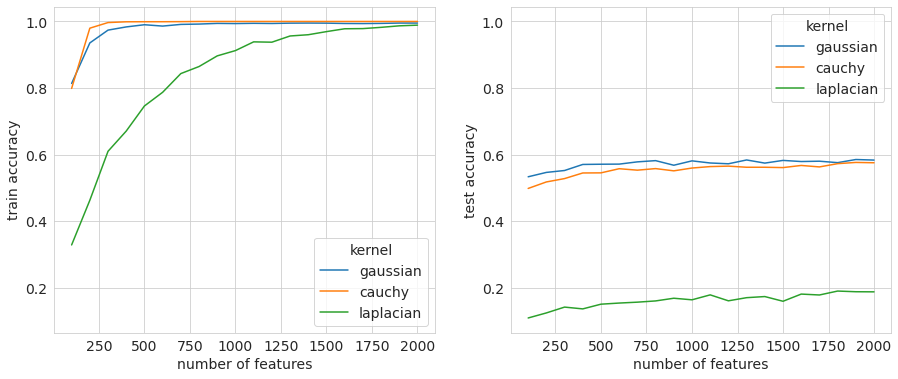

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

sns.lineplot(np.arange(100, 2001, 100), train_accuracy[0], label='gaussian', ax=axs[0])
sns.lineplot(np.arange(100, 2001, 100), train_accuracy[1], label='cauchy', ax=axs[0])
sns.lineplot(np.arange(100, 2001, 100), train_accuracy[2], label='laplacian', ax=axs[0])

sns.lineplot(np.arange(100, 2001, 100), test_accuracy[0], label='gaussian', ax=axs[1])
sns.lineplot(np.arange(100, 2001, 100), test_accuracy[1], label='cauchy', ax=axs[1])
sns.lineplot(np.arange(100, 2001, 100), test_accuracy[2], label='laplacian', ax=axs[1])

for ax in axs:
    ax.set_xlabel('number of features')
    ax.legend(title='kernel')
    ax.yaxis.set_tick_params(labelbottom=True)

axs[0].set_ylabel('train accuracy')
axs[1].set_ylabel('test accuracy')

plt.show()

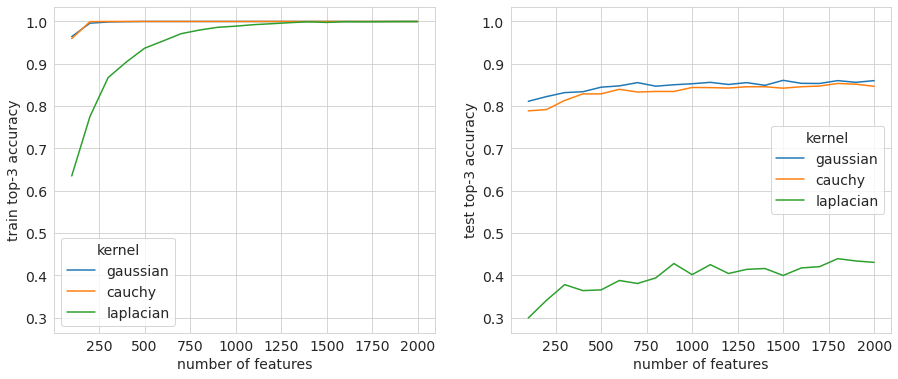

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

sns.lineplot(np.arange(100, 2001, 100), train_top_3_accuracy[0], label='gaussian', ax=axs[0])
sns.lineplot(np.arange(100, 2001, 100), train_top_3_accuracy[1], label='cauchy', ax=axs[0])
sns.lineplot(np.arange(100, 2001, 100), train_top_3_accuracy[2], label='laplacian', ax=axs[0])

sns.lineplot(np.arange(100, 2001, 100), test_top_3_accuracy[0], label='gaussian', ax=axs[1])
sns.lineplot(np.arange(100, 2001, 100), test_top_3_accuracy[1], label='cauchy', ax=axs[1])
sns.lineplot(np.arange(100, 2001, 100), test_top_3_accuracy[2], label='laplacian', ax=axs[1])

for ax in axs:
    ax.set_xlabel('number of features')
    ax.legend(title='kernel')
    ax.yaxis.set_tick_params(labelbottom=True)

axs[0].set_ylabel('train top-3 accuracy')
axs[1].set_ylabel('test top-3 accuracy')

plt.show()

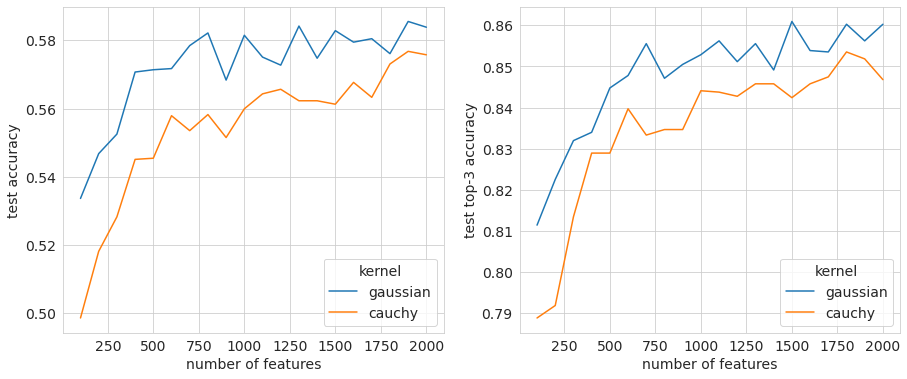

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.lineplot(np.arange(100, 2001, 100), test_accuracy[0], label='gaussian', ax=axs[0])
sns.lineplot(np.arange(100, 2001, 100), test_accuracy[1], label='cauchy', ax=axs[0])

sns.lineplot(np.arange(100, 2001, 100), test_top_3_accuracy[0], label='gaussian', ax=axs[1])
sns.lineplot(np.arange(100, 2001, 100), test_top_3_accuracy[1], label='cauchy', ax=axs[1])

for ax in axs:
    ax.set_xlabel('number of features')
    ax.legend(title='kernel')

axs[0].set_ylabel('test accuracy')
axs[1].set_ylabel('test top-3 accuracy')

plt.show()

## Orthogonal random features

In [0]:
ort_train_accuracy = np.zeros(20)
ort_test_accuracy = np.zeros(20)
ort_train_top_3_accuracy = np.zeros(20)
ort_test_top_3_accuracy = np.zeros(20)

for i, n_features in tqdm(enumerate(np.arange(100, 2001, 100))):
    features = RandomFourierFeatures(kernel='gaussian', orthogonal=True, n_features=n_features, inner_bias=True)
    regr = LogisticRegression(C=100, max_iter=10000)
    for _ in range(3):
        features.fit(X_train)
        XF_train, XF_test = features.transform(X_train[train_mask]), features.transform(X_test)
        regr.fit(XF_train, y_train[train_mask])

        ort_train_accuracy[i] += accuracy_score(y_train[train_mask], regr.predict(XF_train))
        ort_test_accuracy[i] += accuracy_score(y_test, regr.predict(XF_test))
        ort_train_top_3_accuracy[i] += top_3_accuracy_score(y_train[train_mask], regr.predict_proba(XF_train))
        ort_test_top_3_accuracy[i] += top_3_accuracy_score(y_test, regr.predict_proba(XF_test))

ort_train_accuracy /= 3
ort_test_accuracy /= 3
ort_train_top_3_accuracy /= 3
ort_test_top_3_accuracy /= 3

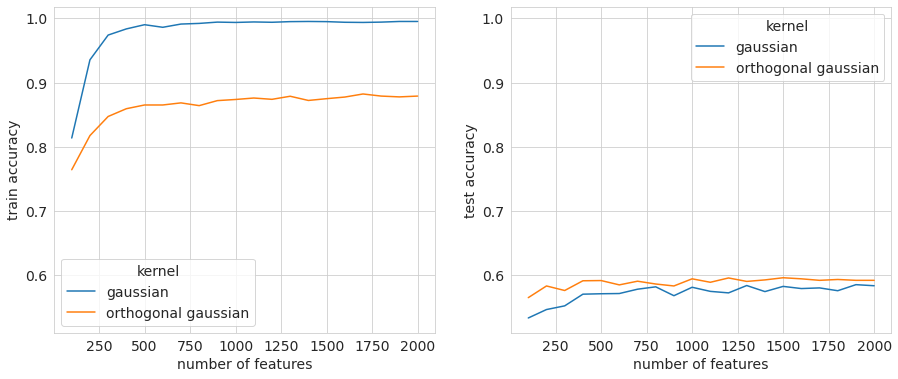

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

sns.lineplot(np.arange(100, 2001, 100), train_accuracy[0], label='gaussian', ax=axs[0])
sns.lineplot(np.arange(100, 2001, 100), ort_train_accuracy, label='orthogonal gaussian', ax=axs[0])

sns.lineplot(np.arange(100, 2001, 100), test_accuracy[0], label='gaussian', ax=axs[1])
sns.lineplot(np.arange(100, 2001, 100), ort_test_accuracy, label='orthogonal gaussian', ax=axs[1])

for ax in axs:
    ax.set_xlabel('number of features')
    ax.legend(title='kernel')
    ax.yaxis.set_tick_params(labelbottom=True)

axs[0].set_ylabel('train accuracy')
axs[1].set_ylabel('test accuracy')

plt.show()

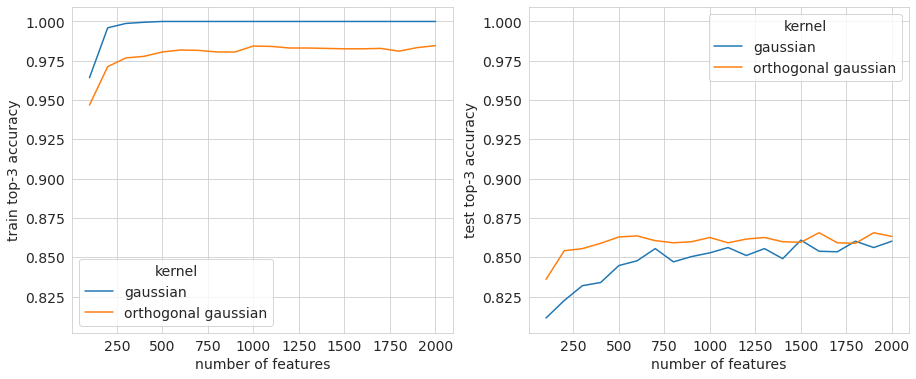

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

sns.lineplot(np.arange(100, 2001, 100), train_top_3_accuracy[0], label='gaussian', ax=axs[0])
sns.lineplot(np.arange(100, 2001, 100), ort_train_top_3_accuracy, label='orthogonal gaussian', ax=axs[0])

sns.lineplot(np.arange(100, 2001, 100), test_top_3_accuracy[0], label='gaussian', ax=axs[1])
sns.lineplot(np.arange(100, 2001, 100), ort_test_top_3_accuracy, label='orthogonal gaussian', ax=axs[1])

for ax in axs:
    ax.set_xlabel('number of features')
    ax.legend(title='kernel')
    ax.yaxis.set_tick_params(labelbottom=True)

axs[0].set_ylabel('train top-3 accuracy')
axs[1].set_ylabel('test top-3 accuracy')

plt.show()

## Regularization

In [0]:
train_accuracy = np.zeros(20)
test_accuracy = np.zeros(20)
train_top_3_accuracy = np.zeros(20)
test_top_3_accuracy = np.zeros(20)

for i, regcoef in tqdm(enumerate(np.arange(0.1, 2.01, 0.1))):
    features = RandomFourierFeatures(kernel='gaussian', orthogonal=True, regcoef=regcoef, inner_bias=True)
    regr = LogisticRegression(C=100, max_iter=10000)
    for _ in range(3):
        features.fit(X_train)
        XF_train, XF_test = features.transform(X_train[train_mask]), features.transform(X_test)
        regr.fit(XF_train, y_train[train_mask])

        train_accuracy[i] += accuracy_score(y_train[train_mask], regr.predict(XF_train))
        test_accuracy[i] += accuracy_score(y_test, regr.predict(XF_test))
        train_top_3_accuracy[i] += top_3_accuracy_score(y_train[train_mask], regr.predict_proba(XF_train))
        test_top_3_accuracy[i] += top_3_accuracy_score(y_test, regr.predict_proba(XF_test))

train_accuracy /= 3
test_accuracy /= 3
train_top_3_accuracy /= 3
test_top_3_accuracy /= 3

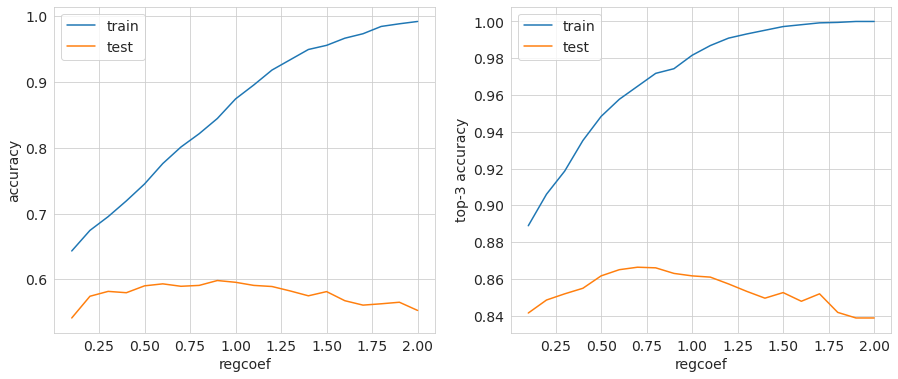

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.lineplot(np.arange(0.1, 2.01, 0.1), train_accuracy, label='train', ax=axs[0])
sns.lineplot(np.arange(0.1, 2.01, 0.1), test_accuracy, label='test', ax=axs[0])

sns.lineplot(np.arange(0.1, 2.01, 0.1), train_top_3_accuracy, label='train', ax=axs[1])
sns.lineplot(np.arange(0.1, 2.01, 0.1), test_top_3_accuracy, label='test', ax=axs[1])

for ax in axs:
    ax.set_xlabel('regcoef')
    ax.legend()

axs[0].set_ylabel('accuracy')
axs[1].set_ylabel('top-3 accuracy')

plt.show()

## Final model

In [0]:
rff = RandomFourierFeatures(n_features=4000, kernel='gaussian', orthogonal=True, regcoef=0.85)
rff.fit(X_train)

In [0]:
XF_train, XF_test = rff.transform(X_train), rff.transform(X_test)

In [0]:
log_regr = LogisticRegression(C=1000, max_iter=10000)
log_regr.fit(XF_train, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
accuracy_score(y_train, log_regr.predict(XF_train)), top_3_accuracy_score(y_train, log_regr.predict_proba(XF_train))

(0.9365596790371113, 0.9929789368104313)

In [0]:
accuracy_score(y_test, log_regr.predict(XF_test)), top_3_accuracy_score(y_test, log_regr.predict_proba(XF_test))

(0.6737373737373737, 0.9)